In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [8.0, 3.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Normal Hierarchical  Models


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on 

* Alicia A. Johnson, Miles Q. Ott, Mine Dogucu, Bayes Rules! An Introduction to Applied Bayesian Modeling, Chapter 16,  *Hierarchical Models without Predictors*, https://www.bayesrulesbook.com/chapter-16.html


# Modeling songs popularity

* Spotify  provides a data bases of songs and their *popularity* score,  which varies over  the 0-100 scale. 


* Higher popularity usually means the song has been played often, especially  recently. 

# Research questions 


*   What’s the typical popularity of a Spotify song?


*   How does popularity vary from artist to artist?


*   For any single artist, how much does popularity vary from song to song?


*  We look for answers with a quantification of the related uncertainty.

# Hierarchical data set

* The data set  comprises  one or more songs for each of the 44 artists 


* The list of artists  is a  sample from the whole population of  artists that have songs on Spotify 

<img src='img/spotify-hierarchical-data-diagram.png' width=600 align="center" >



# The structure of the data

* The $j$ subscript refers to the $j$-th  artist (we have 44 artists).

*  $n_j$: number of songs created by artist $j$.

*  $y_{ij}$:  popularity of the $i$-th song of artist $j$
    * $j \in \{1,2,…,44\}$, $i \in \{1,2,…,n_j\}$.

* The data set is constituted by  44 *sub-populations* (or *clusters*);   each artist provides a cluster of songs.

In [3]:
# the full data set is available from the bayesrule package for R. This is a reduced version which only contains song,
#author and popularity.
#The data set contains 350 songs by 44 artists
spotify = pd.read_csv("data/spotify.csv")

spotify.head()

,artist,title,popularity
0,Alok,On & On,79
1,Alok,All The Lies,56
2,Alok,Hear Me Now,75
3,Alok,The Wall,65
4,Alok,Hear Me Now,52


In [4]:
# we create a list containing the  name of each artist: ['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé', ...]
spotify["artist"] = spotify["artist"].astype("category")
artists = list(spotify["artist"].cat.categories) 

#show the first artists
artists[0:5]

['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé']

In [5]:
# artist_popularity contains the mean popularity of the songs of each artist and the name of the artist
# artist ranked from the less popular one.
artist_popularity=spotify.groupby(['artist']).mean().sort_values('popularity').head()
artist_popularity

,popularity
artist,
Mia X,13.250000
Chris Goldarg,16.400000
Soul&Roll,24.200000
Honeywagon,31.666667
Röyksopp,33.250000


In [6]:
# Number of the songs of each artists; it varies between 2 and 40.
artist_count=spotify.groupby(['artist']).count()
artist_count.head()

,title,popularity
artist,,
Alok,19,19
Atlas Genius,4,4
Au/Ra,5,5
BUNT.,3,3
Beyoncé,25,25


# Modelling approaches

* *Pooled*: merge  data from songs of all artists, without modelling the difference between artists.
     
     
* *Unpooled*:  independently analyzes the songs of every  artist
    * the mean popularity of songs from artist $j$ is $\mu_j$
    * inference about artists with  few published songs is  uncertain
    * cannot predict a novel artist

# Hierarchical model (partial pooling)

* Like the unpooled model, the mean popularity of songs from artist $j$ is  $\mu_j$   
    
       
* additionally, $\mu_j$ is assumed to be a sample from the population of artists: $ \mu_j \sim N(\mu', \sigma_p)$


* where $\mu'$ and $\sigma_p$ are the mean popularity and the std deviation of the $\mu_j$'s. These are parameters to which we will assign priors.





 

# Hierarchical model (partial pooling)

* It places a prior on the parameters of the prior (*hierarchical*).
    
       
* It can make prediction also for an artist for which there are no songs in our sample, based on what it has learned about the populations of artists. Moreover, it  improves the estimates for artists with few songs. 






# Pooled model

<img src='img/spotify-density.png' width=400 align="center" >

*  We fit a  normal-normal model  on all  songs in the sample (density  shown in the plot), ignoring the grouping structure implied by the different authors.


# Pooled model

* We fit a normal-normal model on  the data set containing all songs.
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu} ) \\
\sigma & \sim \text{HalfNormal}(\xi)\\
\vec{y_{ij}} & \sim N(\mu, \sigma)
\end{align*}

*  $\mu$ and $\sigma$ are   *global* parameters, which apply to every song.


# Prior on $\mu$

* A priori,  we assume $\mu$ to lie in  (30, 70).

* Interpreting the  interval as a region of $\pm$2 standard deviations, our prior beliefs about the mean of the population is:

$$ \mu \sim N(50, 10) $$



# Prior on $\sigma$

In [7]:
# sigma controls the spread of popularity in the whole population of songs
# We can interpret the range (0 , 100) as a range with length 4 stds (+-2 std around the mean).
# Thus a plausible value of  sigma is  25. 
#This is slightly in excess, as some density is outside the allowed range (0,100).

# Using  scale 36, we get the median of the distribution close to 25.
from scipy.stats import halfnorm 
pd.DataFrame(halfnorm.rvs(scale=36, size=10000)).describe()

,0
count,10000.000000
mean,28.907927
std,21.774580
min,0.005977
25%,11.770519
50%,24.481657
75%,41.423314
max,137.738299


# Pooled model


\begin{align*}
\mu    & \sim N(50, 10) \\
\sigma & \sim\text{HalfNormal} (36) \\
\vec{y_{ij}}  & \sim N(\mu, \sigma) \\
\end{align*}

In [8]:
with pm.Model() as pooled_model:
    # prior
    global_mean    =  pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 36)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, global_mean]


/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [9]:
# The Spotify songs have an average popularity of about 58.
# There is  a  large standard deviation  (global_sigma) of popularity  from song to song,
#of about 20 points. The data set has large variability, as it contains songs from different authors. 
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mean,58.308,1.114,56.199,60.326,0.018,0.013,3656.0,2610.0,1.0
global_sigma,20.726,0.809,19.307,22.325,0.014,0.010,3556.0,2772.0,1.0


# Quiz yourself

* How would you make  a prediction using the  pooled model for:

    * a new song of  Mia X, the artist with the lowest mean popularity  (13) in the sample? 
    * Beyoncé, the artist with the highest mean popularity (70) in the sample?
    * a group not present in the sample?
   

# Answer
* The  complete pooled model ignores the artist; the prediction for the new song of every author (including unknown authors) is identical.

# Predicting the popularity of the next song (*predictive distribution*)

* The trace contains 4000 parameter samples  $<\mu_s, \sigma_s>$. 

* For each sample  we draw  a possible future value of popularity as:

$$
y_s^{\text{new}}  \sim \; N\left(\mu_s, \sigma_s\right)\;\; s=1,2...4000$$



# Predictive distribution for a specific artist

$$
\left[
\begin{array}{ll} 
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y^{\text{new}}_{1} \\
y^{\text{new}}_2 \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

The predictive distribution accounts for:
   * uncertainty in the parameters of $\mu, \sigma$
   * uncertainty due to stochastic sampling from a normal distribution.

In [10]:
#predictive distribution implemented in pymc3
#this is more convenient, but less didactic, than implementing a for loop on the raw values of the trace.
with pm.Model() as pooled_model:
    # prior
    global_mean    =   pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 36)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    
    #prediction, computed for every posterior sample of global_mean and global_sigma.
    predictive          =  pm.Normal('predictive', mu=global_mean, sigma=global_sigma )
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [predictive, global_sigma, global_mean]


/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [11]:
#this prediction is the same for every artist.
az.summary(trace_pooled, var_names='predictive')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
predictive,58.251,21.086,18.286,96.654,0.287,0.209,5357.0,2897.0,1.0


# Unpooled model

* It independently analyzes the songs of each artist.


* The  mean popularity of the $j$-th artist is  $\mu_j$.


* One artist’s mean doesn’t tell us anything about another’s.

# Unpooled model 

<img src='img/spotify-unpooled.png' width=500 align="center" >

* The popularity of the songs produced by artist $j$ are distributed $N(\mu_j, \sigma)$.


* We assume   $\sigma$ to be common to all artists.


      

# About the common sigma

* This  assumption of common $\sigma$ is reasonable and simplifies the inference (we have 45 parameters rather than 88). 


* It could be  worth implementing also a  model with a different $\sigma$ for each artist and comparing the two models (model selection can be done using WAIC, a topic covered later in the course).


# Unpooled model

* The priors are the same of the pooled model. But every $\mu_j$ is now an independent parameter.

\begin{align*}
\mu_j    & \sim N(50, 20)  \; \; \; j=1,2...44\\
\sigma & \sim \text{HalfNormal}(30) \\
y_{ij}  & \sim N(\mu_j, \sigma) \\
\end{align*}

In [12]:
#The code below assigns a  numerical code to each author; then it assigns to each song the code of its author.
n_artist = len(artist_count) #44

#names of the authors of each song
artist       = spotify['artist'].values

#names mapped into codes
spotify['artist_code']  = spotify['artist'].astype('category').cat.codes


#how many songs from Beyoncé and BUNT.
beyonce_code = np.asscalar(np.unique(spotify['artist_code'][spotify['artist']=='Beyoncé']))
bunt_code       = np.asscalar(np.unique(spotify['artist_code'][spotify['artist']=='BUNT.']))
print('songs from Beyoncé: ', np.sum(spotify['artist'] == 'Beyoncé'))
print('songs from BUNT.: ', np.sum(spotify['artist'] == 'BUNT.'))

#show the data structure
print(spotify[['artist', 'artist_code']])

songs from Beyoncé:  25
songs from BUNT.:  3
        artist  artist_code
0         Alok            0
1         Alok            0
2         Alok            0
3         Alok            0
4         Alok            0
..         ...          ...
345  Zeds Dead           43
346  Zeds Dead           43
347  Zeds Dead           43
348  Zeds Dead           43
349  Zeds Dead           43

[350 rows x 2 columns]


/var/folders/2k/rgs_y6s556x557660m9wmrfc0000gp/T/ipykernel_2327/1452641053.py:12: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  beyonce_code = np.asscalar(np.unique(spotify['artist_code'][spotify['artist']=='Beyoncé']))
/var/folders/2k/rgs_y6s556x557660m9wmrfc0000gp/T/ipykernel_2327/1452641053.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  bunt_code       = np.asscalar(np.unique(spotify['artist_code'][spotify['artist']=='BUNT.']))


In [13]:

with pm.Model() as unpooled_model:
    # A vector of independent means, one for each artist. Notice the keyword 'shape'.
    mu_artist            =  pm.Normal ('mu_artist', 50,  20, shape = n_artist)
    
    #The common sigma, shared among all authors.
    global_sigma    =  pm.HalfNormal ('global_sigma', sd = 30)

    #spotify["popularity"] is the vector of popularities of each song; 
    #spotify['artist_code'] is a vector containing the code of the author of each song.
    popularity      =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_unpooled  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mu_artist]


/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [14]:
# posterior mean of each artist (only the first ones are shown).
#The mean is different for each artist.
# The uncertainty about the posterior mean is represented by the length of its HDI.
# Artist with many songs (like Beyoncé) have shorter HDI compared to artists with less songs(like BUNT.) 

# assing_coords is  used to assign  the artist name to each element of the vector mu_artist, and show the names in the summary.
posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
az.summary(posterior).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_artist[Alok],64.469,3.168,58.458,70.292,0.034,0.024,8898.0,3119.0,1.0
mu_artist[Atlas Genius],46.160,6.632,33.347,58.311,0.067,0.049,9637.0,3160.0,1.0
mu_artist[Au/Ra],59.881,5.923,49.078,71.099,0.064,0.046,8493.0,2607.0,1.0
mu_artist[BUNT.],43.275,7.492,28.638,56.747,0.075,0.055,9966.0,3084.0,1.0
mu_artist[Beyoncé],69.329,2.795,64.129,74.548,0.026,0.019,11349.0,2722.0,1.0


In [15]:
# the global_sigma represents the variations between songs produced by the same artist.
# It is the same for every artist.
# It is lower compared to the pooled model, as it only accounts for variations between songs of the same artists.
az.summary(trace_unpooled, var_names='global_sigma')


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_sigma,14.01,0.553,13.015,15.066,0.007,0.005,6158.0,3214.0,1.0


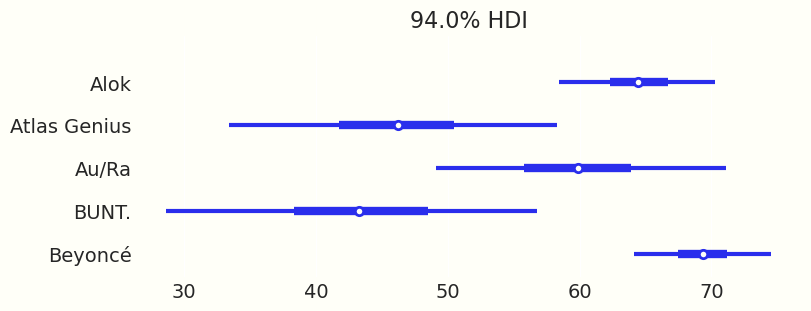

In [16]:
# The forest plot compares HDI intervals from a number of distributions  (different artists in our case).
#The HDIs are shorter for artists that have published more songs.
#We show only the first 5 artists: we limit and label the graph using the coords option. 

axes = az.plot_forest (trace_unpooled, var_names="mu_artist",
                       combined=True, # a single plot for each artist,  merging  samples from different chains.
                       coords={"mu_artist_dim_0": range(5)}, figsize=(8, 3))
artists_5 = artists[:5]
axes[0].set_yticklabels(artists_5[::-1]);

# Predictive distribution for a specific artist

* Select the posterior samples of $\mu_{\text{Beyoncé}}$ and $\sigma$, and sample using a normal distribution.

$$
\left[
\begin{array}{ll} 
\mu_{\text{Beyoncé},1} &   \sigma_1 \\
\mu_{\text{Beyoncé},2}  & \sigma_2 \\
\vdots & \vdots  \\
\mu_{\text{Beyoncé},4000}   & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y_{\text{Beyoncé},1}^{\text{new}} \\
y_{\text{Beyoncé},2}^{\text{new}}\\
\vdots \\
y_{\text{Beyoncé},4000}^{\text{new}}\\
\end{array}
\right]
$$

The predictive distribution accounts for:
   * uncertainty in the parameters of $\mu_{\text{Beyoncé}}, \sigma$
   * uncertainty due to stochastic sampling from a normal distribution.

In [17]:
#predictive distribution for Beyonce, implemented in Pymc3

with pm.Model() as unpooled_model_with_preds:
    
    #lines below as in the unpooled model 
    mu_artist         =  pm.Normal ('mu_artist', 50,  20, shape= n_artist)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)
    popularity         =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    #predictive distribution for specific artists
    pred_beyonce   = pm.Normal ('pred_beyonce', mu = mu_artist[beyonce_code],  sigma = global_sigma)
    
    trace_unpooled_with_preds  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pred_beyonce, global_sigma, mu_artist]


/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [18]:
#Notice the larger uncertainty of predictive distribution, compared to the uncertainty on the posterior mean
#Can you explain the reason?
az.summary(trace_unpooled_with_preds, var_names=['pred_beyonce'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_beyonce,69.358,14.508,40.619,97.974,0.158,0.121,8394.0,2962.0,1.0


# Discussion

* Posterior mean popularity of Beyonce': 
    * the HDI is between the .025 and .975 percentile of the posterior samples of $\mu_{\text{beyonce}}$
    

* Predictive distribution for the next song by Beyonce': 
    * the HDI is between the .025 and .975 percentile of the samples $y^{\text{new}}_{\text{beyonce}}$



# Discussion

The no pooled model represents the diversity between  artists with two shortcomings:

* estimates for artists with few songs are  uncertain
    
* it  does not model the *population* of  artists. Even though we have analyzed 44 artist, we are unable to say anything about a  Spotify artist not yet present in the sample.

# Hierarchical model

\begin{equation}
\begin{array}{lrl}
\text{Layer 1:} & \hspace{-0.05in} y_{ij} \sim N( \mu_j, \sigma) & \hspace{-0.075in} \text{how  popularity varies WITHIN the songs of artist } j \\
\text{Layer 2:} & \hspace{-0.05in} \mu_j \sim N( \mu', \sigma_\mu) & \hspace{-0.075in}  \text{population of artists:  how  $\mu_j$ varies BETWEEN artists}\\
\text{Layer 3:} & \hspace{-0.05in} \text{densities for } \mu, \sigma, \sigma_\mu  & \hspace{-0.075in} \text{prior  for shared  parameters} \\
\end{array}
\end{equation}

* There is a prior over $\mu'$ and $\sigma_{\mu}$ (which are instead fixed numbers in the normal-normal model). This is a *hierarchy* of priors.

# Individual songs for each artist.

* As in the unpooled model,  the popularity of songs  of  artist $j$ are assumed:

$$  y_{ij} \sim N(\mu_j, \sigma) $$


*  $σ$ is the global sigma, which is equal for  all artists.

# Population of artists



* The 44 $\mu_j$'s  are samples  from the population of Spotify artists:


$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$

* $\mu'$: mean popularity in the population of the Spotify artists (mean of the $\mu_j$'s in the whole population)
* $\sigma_{\mu}$: spread between the  $\mu_j$'s, i.e., between the popularity of the different artists

# Modeling the population of artists

$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$


* We want to learn the population of artists.
* Both $\mu'$ and $\sigma_{\mu}$ are  *parameters*, to which we will assign a prior.

# Notation alert

*  $\mu_j$: mean popularity of songs from  the j-th artist
* $\mu'$: mean value of the $\mu_j$'s within the whole  population of artists


* $\sigma$:  standard deviation of popularity between songs from the same author. 
* $\sigma_{\mu}$ standard deviation of the $\mu_j$ within the population of artists.

# Priors for  $\mu'$ and  $\sigma_{\mu}$

\begin{align*}
\mu'           & \sim N(50, 20) && \text{95% pred interval is (50 +- 40)} \\
\sigma_\mu & \sim \text{Half Normal}(6)    && \text{spread betweent the different mu_j : see next slide}  \\
\end{align*}

In [19]:
# how to choose the priors on sigma_mu
# We assume the various mu_j  to vary in 0,100; hence a plausible sigma_mu is 15 (the HN has a long right tail anyway)
pd.DataFrame(np.abs(np.random.normal(0, scale=22, size=10000))).describe(percentiles=[0.50, 0.75, 0.95])

,0
count,10000.000000
mean,17.525789
std,13.413570
min,0.002317
50%,14.572239
75%,25.324572
95%,43.562036
max,89.381393


In [20]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:
    
    # prior on the parameters of the population of artists (hyper-priors). 
    
    # prior beliefs about the mean value and the spread of the different mu_j
    #This is where the hierarchical model differs from the unpooled model.
    mu_pop         = pm.Normal ('mu_pop', 50,  20)
    sigma_mu     = pm.HalfNormal ('sigma_mu', 22)
    
    
    # layer 2: each artist is a sample from the population of artists; we sample n_artist times from such population.
    mu_artist        =  pm.Normal ('mu_artist', mu=mu_pop, sigma=sigma_mu, shape= n_artist)
    
    # global_sigma (spread between songs of the same authors) is as in the unpooled model.
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)

    #Popularity of each song is a sample from N(mu_j, global_sigma).
    popularity    =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_hier    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mu_artist, sigma_mu, mu_pop]


/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


# Parameters
* The hierarchical Spotify model  has  47 parameters:
    * 44 artist-specific parameters $\mu_j$
    * 2 parameters for the population of artists: $\mu',   \sigma_{\mu}$
    * the global sigma $\sigma$

In [21]:
#mu_pop is indeed close to 50 as we assumed
#the 95% popularity of the artists varies in roughly 52 +- 30
#the songs of a given author are comprised with 95% probability within a range of +-28 around its mean.
az.summary(trace_hier, var_names=["mu_pop", "sigma_mu", "global_sigma", "mu_artist"])[["mean","hdi_3%","hdi_97%","r_hat"]].head()

,mean,hdi_3%,hdi_97%,r_hat
mu_pop,52.405,47.702,57.224,1.0
sigma_mu,15.158,11.592,18.700,1.0
global_sigma,14.035,12.958,15.122,1.0
mu_artist[0],64.290,58.429,70.385,1.0
mu_artist[1],46.921,33.825,58.466,1.0


In [22]:
# preparing the traces, to be able to access using names. 
#this way the name of the artist is assigned to each mu_j
#the trace object has an internal field called mu_artist_dim_0
trace_unpooled.posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
trace_hier.posterior = trace_hier.posterior.assign_coords(mu_artist_dim_0=artists)

In [23]:
#estimated mean popularity of each artist, according to the unpooled and to the hierarhical model
# the estimates of the hierarchical model are pulled towards to general mean (shrinkage).
axes = az.plot_forest([trace_unpooled_, trace_hier_], model_names=['unpooled_model', 'hier_model'], combined=True,
                      var_names='mu_artist', hdi_prob=0.95, coords={"mu_artist_dim_0": artists[0:18]},  figsize=(8, 4));
#mean popularity of all songs
grand_mean = spotify["popularity"].mean()
axes[0].axvline(x=grand_mean);

NameError: name 'trace_unpooled_' is not defined

# Shrinkage: pulling the estimates towards the grand mean

*  The pooled  model ignores the fact that our data is grouped by artist.


*  The unpooled model separately analyzes each artist ignoring the information about the grand mean.


* The hierarchical model pulls  the estimates of the unpooled model  towards the grand mean (*shrinkage*).


# Shrinkage

* Given $\sigma^2$ and  $\sigma^2_{\mu}$, the posterior mean of the hierarchical model for  artist $j$  is: 

$$
\overline{\mu}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2}{\sigma^2 + n_j \sigma^2_{\mu}}
}_{\text{weight of the grand mean}}
\overline{\mu}_{\text{pooled}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2+ n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{\mu}_j
$$

* We denote by $\overline{\mu}$ the posterior mean.

# Shrinkage

* Given $\sigma^2$ and  $\sigma^2_{\mu}$, the posterior mean of the hierarchical model for  artist $j$  is: 

$$
\overline{\mu}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2}{\sigma^2 + n_j \sigma^2_{\mu}}
}_{\text{weight of the grand mean}}
\overline{y}_{\text{global}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2+ n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{y}_j
$$


* If $n_j$ is large, it is the same estimate of the unpooled model.

* If $n_j$ is 0, it is the grand mean (like the pooled model).

* If $\sigma_{\mu}$ is large, the estimates are close to the unpooled model, because the population of artists is very dispersed.

# Shrinkage

$$
\overline{y}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2}{\sigma^2 + n_j \sigma^2_{\mu}}
}_{\text{weight of the grand mean}}
\overline{y}_{\text{global}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2+ n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{y}_j
$$


* In our  case both variances are parameters. Hence the model behavior is more complex, as there is uncertainty about the parameters (the above formula is  computed for each sample of the parameters). Yet, we can use  the above formula to understand *shrinkage*.

# Shrinkage

$$
\overline{y}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_{\mu}}
}_{\text{weight of the global model}}
\overline{y}_{\text{global}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2_y + n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the  model}}
\overline{y}_j
$$

* Scenarios in which the hierarchical posterior predictions shrinks towards the global mean:

*  $n_j$ is low:  we rely more on global trends to understand a group for which we have little data.

* the variability of popularity for songs of the same artist ($\sigma_y$) is large in comparison to the variability the mean populatrity of the artists $\sigma_{\mu}$.

*  the models learns that  artist are very similar to each other ($\sigma_{\mu}$ is low), it increases the weight of the pooled model.

In [ ]:
# here we define shrinkage as the difference between the posterior mean of the hierarchical model 
# and the unpooled model, in absolute valuE.
# We show the amount of shrinkage, in absolute value, as a function of the number of songs for each artist

n_j = spotify['artist'].value_counts(sort=False)
mean_unpooled = az.summary(trace_unpooled, var_names=["mu_artist"])["mean"]
mean_hier = az.summary(trace_hier, var_names=["mu_artist"])["mean"]

#absolute value of the shrinkage
shrinkage = pd.Series((mean_hier-mean_unpooled).values, index=artists).abs()

df = pd.concat([n_j, shrinkage], axis=1)
df.columns = ["n_j", "shrinkage"]
plt.plot(df["n_j"], df["shrinkage"], "*")
plt.xlabel("n_j")
plt.ylabel("shrinkage"); 

# Predictive distribution for the next song of a  known artist

* Make a prediction about the popularity of the next song of Beyoncé.

* Select the posterior samples of $\mu_{\text{Beyoncé}}$ and $\sigma$, and sample using a normal distribution.

$$
\left[
\begin{array}{ll} 
\mu_{\text{Beyoncé},1} &   \sigma_1 \\
\mu_{\text{Beyoncé},2}  & \sigma_2 \\
\vdots & \vdots  \\
\mu_{\text{Beyoncé},4000}   & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y_{\text{Beyoncé},1}^{\text{new}} \\
y_{\text{Beyoncé},2}^{\text{new}}\\
\vdots \\
y_{\text{Beyoncé},4000}^{\text{new}}\\
\end{array}
\right]
$$

* The predictive distribution of  the unpooled model is computed in the same way (though $\mu_{\text{Beyoncé}}$ might be pulled towards the general mean by the hierarchical model).

# Predictive distribution for the first song artist of a new artist 

* This requires two sampling steps: first we sample the $\mu_j$ of the new artist from the population of artists.

* Given the samples of $\mu_j$, we follow the same procedure for known artists.



# Predictive distribution for the first song artist of a new artist 

* We create samples for a generic new artist (named 'ABC') by using the  posterior samples of $\mu'$ and $\sigma_{\mu}$. 

* For each sample $< \mu'_s, \sigma_{\mu,s}>$, we draw a value from $N (\mu'_s, \sigma_{\mu,s})$.

$$
\left[
\begin{array}{ll} 
\mu'_{,1} &   \sigma_{\mu,1} \\
\mu'_{,2}  & \sigma_{\mu,2} \\
\vdots & \vdots  \\
\mu_{',4000}   & \sigma_{\mu,4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
\mu_{\text{ABC},1} \\
\mu_{\text{ABC},2}\\
\vdots \\
\mu_{\text{ABC},4000}\\
\end{array}
\right]
$$

# Predictive distribution for the next song of a  known artist

* For each posterior sample  $<\mu_{\text{ABC},s}, \sigma_s>$, draw a value from $N(\mu_{\text{ABC},s}, \sigma_s)$.

$$
\left[
\begin{array}{ll} 
\mu_{\text{ABC},1} &   \sigma_1 \\
\mu_{\text{ABC},2}  & \sigma_2 \\
\vdots & \vdots  \\
\mu_{\text{ABC},4000}   & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y_{\text{ABC},1}^{\text{new}} \\
y_{\text{ABC},2}^{\text{new}}\\
\vdots \\
y_{\text{ABC},4000}^{\text{new}}\\
\end{array}
\right]
$$

# Your turn

Compute:

* the predictive distribution for the next song of Beyonce and BUNT using to the hierarchical and the unpooled model; comment the results.


* the predictive distribution for the first song of a a new artist using to the hierarchical model.


# Your turn - 2

* Alicia loves typing. She invites four friends to each take 20 times a  speed-typing test. Let $y_{ij}$ be the time it takes friend $j$ to complete test $i$.

 * In modeling $y_{ij}$, formalize a hierarchical model and interpret  the meaning of $μ_j$, $μ'$, $σ$, $σ_{\mu}$.
    
2) Consider the following scenarios and discuss their effect on the posterior distribution of the parameters:

    * Each person is quite consistent in their typing times, but there are big differences from person to person – some tend to type much faster than others.
    * The overall results of the 20 timed tests are remarkably similar among the four friends.


* For each scenario, indicate whether:
* $ \sigma < \sigma_{\mu}$. 
* $ \sigma ≈σ_μ$. 
* $  \sigma >σ_μ$. 

# Grouping variable or covariate?

* Suppose our dataset includes a categorical variable  $X$


* Should $X$  be modeled  hierarchically or as a categorical variable (categorical covariate)?

    *   if the observed data on $X$ covers all categories of interest, it is  better treated as a covariate
    
    *  if the observed categories is a random sample from many possible ones, it is a potential grouping variable.


# Grouping variable or covariate?


* Our data set includes only  44 among thousands of artists on Spotify. Hence, treating artist as a covariate (as in the unpooled model) would limit our understanding only to  this small number of artists.


* Treating it as a grouping variable (as in the hierarchical model) allows us to not only learn about the 44 artists in our data, but the broader population of artists from which they were sampled.


# Grouping variable or covariate?

* Consider a daily data set of bike-sharing covering two years; for each day we know whether it was a weekday or a weekend.

* Is the weekend variable a grouping variable or  a covariate?

    * There are only two possible categories: weekend and weekday.
    * The dataset covers both categories, with many observations for each category.
    * Hence  it is a covariate.

# Grouping variable or covariate?

* Consider a data set containing math scores  from a sample of 10 Swiss primary schools. 


* These 10 schools are merely a small sample from the hundreds  of Swiss primary schools.
    * The `school_id`, treated as a covariate (unpooled model) would only allow us to learn about our small sample of schools.
    * Treating it as a grouping variable in a hierarchical model  would allow us to extend our conclusions to the broader population of all schools; this is a better modelling choice.
    
    
* The same consideration applies if you want to analyze e.g. data of a certain disease collected by different hospitals, in which case the involved hospitals can be modelled as a grouping variable.

# Solutions

In [ ]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model_with_preds:
    
    # layer 1: prior on the parameters of the population of artists (hyper-priors). 
    # prior beliefs about the location of the mean popularity within the population of artists
    mu_population          = pm.Normal ('mu_p', 50,  20)
    sigma_mu = pm.HalfNormal ('sigma_mu', 6)
    sigma_y      = pm.HalfNormal ('sigma', 15)

    
    # layer 2: model of the population of artists.
    mu_artist  =  pm.Normal ('mu_artist', mu_population,  sigma_mu, shape= n_artist)
    sigma_y     = pm.HalfNormal ('sigma_y', sd = sigma_y)

    #layer 3 (observation specific for each artist)
    popularity    =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_y, observed = spotify["popularity"])
    
    # == PREDICTIONS
    #prediction of popularity for the next song of  artist 25
    prediction_artist25 = pm.Normal('prediction_artist25', mu = mu_artist[25],  sigma = sigma_y)
    
    #prediction of popularity for a song from a  novel artist. This requires two steps.
    # step 1:  sample the popularity mu_j of the new artist, by sampling from the population of artists.
    mu_new_artist = pm.Normal('new_mean', mu=mu_population, sigma=sigma_mu)
    # step 2:  sample the popularity of a song using the sampled values mu_j for the unknown artist popularity
    prediction_new_artist = pm.Normal('prediction_new_artist', mu = mu_new_artist,  sigma = sigma_y)
    
    trace_hier_with_preds   = pm.sample(return_inferencedata=True)

In [ ]:
# notice the substamtial uncertainty for the prediction of the new artist
az.summary(trace_hier_with_preds, var_names=['prediction_artist25', 'prediction_new_artist'])

In [31]:
#prediction for Beyonce
post_hier                 = az.extract_dataset(trace_hier.posterior)
mu_beyonce_hier  = post_hier.mu_artist[beyonce_code].values
global_sigma_hier = post_hier.global_sigma.values

post_unpooled                 = az.extract_dataset(trace_unpooled.posterior)
mu_beyonce_unpooled  = post_unpooled.mu_artist[beyonce_code].values
global_sigma_unpooled  = post_unpooled.global_sigma.values


y_beyonce_hier = np.zeros(len(mu_beyonce_hier))
y_beyonce_unpooled = np.zeros(len(mu_beyonce_hier))

for i, current_mu in enumerate(mu_beyonce_hier):
        y_beyonce_hier[i]          = np.random.normal (loc = mu_beyonce_hier[i], scale = global_sigma_hier[i])
        y_beyonce_unpooled[i] = np.random.normal (loc = mu_beyonce_unpooled[i], scale = global_sigma_unpooled[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce. 
print('hier: \n')
print(pd.DataFrame(y_beyonce_hier).describe(percentiles=[0.025, 0.975]))


print('unpooled: \n\n')
print(pd.DataFrame(y_beyonce_unpooled).describe(percentiles=[0.025, 0.975]))

hier: 

                 0
count  4000.000000
mean     69.098322
std      14.341820
min      19.102707
2.5%     41.222968
50%      69.080017
97.5%    97.327781
max     122.800437
unpooled: 


                 0
count  4000.000000
mean     69.493961
std      14.276190
min      15.474848
2.5%     41.325906
50%      69.720778
97.5%    97.031983
max     116.135413


In [32]:
#prediction for a novel artist
post_hier                = az.extract_dataset(trace_hier.posterior)

#posterior parameters of the population
mu_population     = post_hier.mu_pop.values
sigma_population = post_hier.sigma_mu.values

mu_new_artist  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_artist[i] = np.random.normal (loc = mu_population[i], scale = sigma_population[i])

#now we have the distribution for the mean of the novel artist.
#we thus compute the distribution for its next song
global_sigma = post_hier.global_sigma.values
popularity_new_song_new_artist  = np.zeros(len(global_sigma))

for i, current_mu in enumerate(mu_population):
        popularity_new_song_new_artist[i] = np.random.normal (loc = mu_new_artist[i], scale = global_sigma[i])

#we obtain a  large predictive distribution, whose 95% hdi varies between 9.8 and 94.
pd.DataFrame(popularity_new_song_new_artist).describe(percentiles=[0.025, 0.975])        

,0
count,4000.000000
mean,52.204284
std,21.351601
min,-27.159424
2.5%,9.850975
50%,52.075956
97.5%,94.059810
max,150.356733
